# Classification

Let us define the basic imports and a `pprint` function.

In [77]:
import numpy as np
import sklearn
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
from IPython.display import display, Math
from numpyarray_to_latex.jupyter import to_ltx
import matplotlib.pyplot as plt
plt.style.use(['seaborn-v0_8-muted', 'practicals.mplstyle'])
def pprint(*args):
    res = ""
    for i in args:
        if type(i) == np.ndarray:
            res += to_ltx(i, brackets='[]')
        elif type(i) == str:
            res += i
    display(Math(res))

## Introduction
In classification problem, the target is a category (a discrete variable) and its conditional distribution is 

$$P({y}|x)$$

where:
- $\mathbf{y} \in \{ c_1,\dots, c_K\}$ represents the output variable (also called target)
- $x \in \mathbb{R}^n$ represents the vector of inputs (also called features)

In classification, the goal of learning is to return an estimator 

$$h(x,\alpha)$$

of the conditional probabiity $P({\mathbf y}|x)$, where $\alpha$ denotes the set of parameters of the model $h$. 

The learning of the estimator is done  on the basis of an available input/output
training set $D_N$ made of $N$ observation pairs $(x_i,y_i)$ where $x_i \in \mathbb{R}^n$. 

## Data generation
As seen in the theoretical course, there are multiple ways to generate datasets for binary classification problems.
### Generative way:
First, generate the class $y_i \in \{0, 1\}$, $i \in \{1,...,N\}$, using the _a priori_ probability, then generate the $x$ values, given the **class conditional density $p(x | \mathbf{y}=y_i)$**.

In [60]:
np.random.seed(1)

If we name the _a priori_ probability $p_1 = P(\mathbf{y} = 1)$, we can generate the $Y$ dataset:

In [61]:
N = 2000
n = 2
p1 = 0.4

Y = np.random.choice([0, 1], size=N, p=[1-p1, p1])

Then, we can generate the $X$ dataset, following two multivariate normal distribution (recall practical 1). We define two distributions, for each of the two classes. Then, depending on the $y$ class of each item, we sample the corresponding multivariate normal distribution. 

Here, to make sure that `cov0` and `cov1` are defined positive, we generate a random $A$ matrix, then `cov` is computed as $A^TA$.

In [62]:
A0 = np.random.rand(n, n)
cov0 = A0.T @ A0
mu0 = (0, 0)

A1 = np.random.rand(n, n)
cov1 = A1.T @ A1
mu1 = (0.75, 0)

In [63]:
X = np.zeros((N, n))
for i in np.arange(N):
    if Y[i] == 1:
        X[i, :] = np.random.multivariate_normal(mu1, cov1, size=1)
    else:
        X[i, :] = np.random.multivariate_normal(mu0, cov0, size=1)

Then, we plot the generated data. 

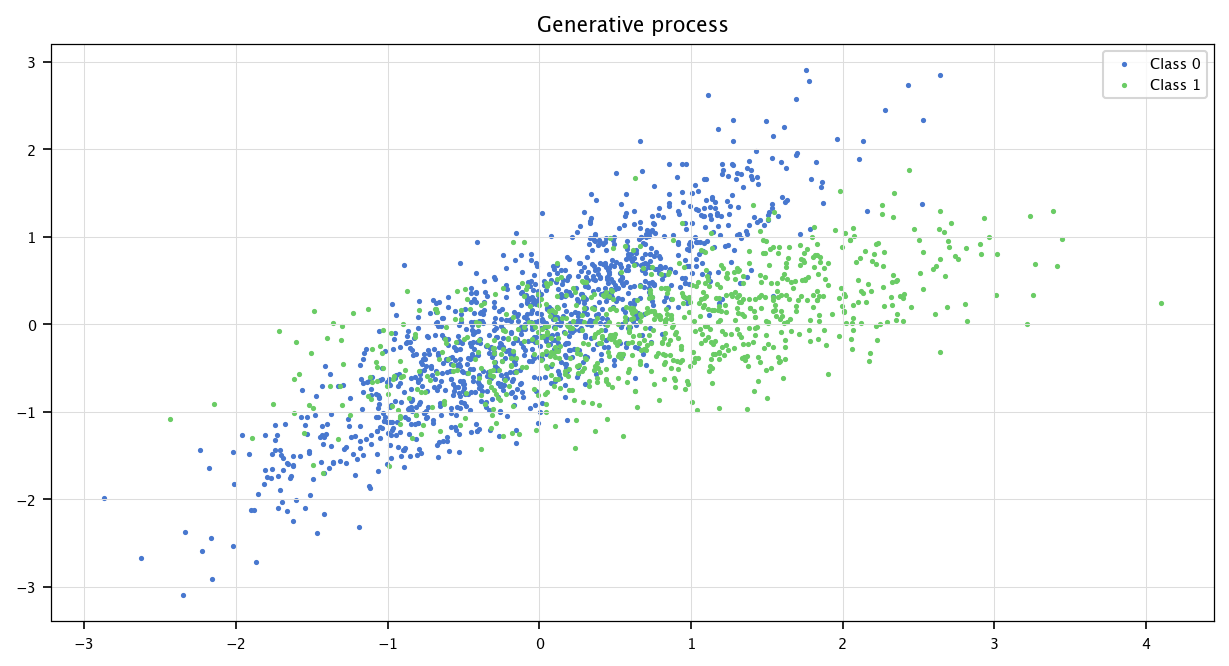

In [78]:
I0 = np.where(Y==0)
I1=np.where(Y==1)

plt.figure(figsize=(10, 4))
plt.scatter(X[I0, 0], X[I0, 1], marker='.', label="Class 0")
plt.scatter(X[I1, 0], X[I1, 1], marker='.', label="Class 1")
plt.grid("on")
plt.legend()
plt.title("Generative process")
plt.show()

### Discriminative way
Otherwise, if we have the conditional distributions $P(y|x)$, we can first sample $x$, then determine the class $y$.

In [36]:
from scipy.stats import multivariate_normal

First, we sample $x$ according to the probability density function:

$$p(x)= p_1*p(x|y=1) + (1-p_1)*p(x|y=0)$$

Those are mixture of gaussians (recall: practical 1).

In [37]:
X = np.zeros((N,n))
for i in np.arange(N):
    if np.random.uniform()<p1:
        X[i,:] = np.random.multivariate_normal(mu1, cov1, size=1)
    else:
       X[i,:] = np.random.multivariate_normal(mu0, cov0, size=1)  

Then, using the Bayes theorem, we compute the $y$ classes.

Recall the Bayes theorem

$$P(\mathbf{y}=y|x) = \frac{p_\mathbf{x}(x|\mathbf{y}=y)P(\mathbf{y}=y)}{p_\mathbf{x}(x)}$$

In order to compute the term $p_\mathbf{x}(x|\mathbf{y}=y)$, we need to make an hypothesis on the distribution of $\mathbf{x}$ according to $\mathbf{y}=y$. Here, since we know that the input features follow a gaussian law (if $\mathbf{y} = 0$, then $\mathbf{x} \sim \mathcal{N}(\mu_0, \Sigma_0)$ and if $\mathbf{y} = 1$, then $\mathbf{x} \sim \mathcal{N}(\mu_1, \Sigma_1)$), we can us to use the `pdf` function from the `multivariate_normal` library already presented.

In the binary case, we can rewrite the formula as

$$P(\mathbf{y}=0|x) = \frac{p_\mathbf{x}(x|\mathbf{y}=0)P(\mathbf{y}=0)}{p_{\mathbf{x}}(x|\mathbf{y}=0)P(\mathbf{y}=0)+p_{\mathbf{x}}(x|\mathbf{y}=1
)P(\mathbf{y}=1)}$$

The previous formula is directly implemented by:

In [38]:
def condprob(x, cov1, mu1, cov0, mu0, p1):
    return multivariate_normal.pdf(x, mean=mu1, cov=cov1)*p1/(multivariate_normal.pdf(x, mean=mu1, cov=cov1)*p1+multivariate_normal.pdf(x, mean=mu0, cov=cov0)*(1-p1))

where $P(\mathbf{y}=y|x)$ is computed by `condprob`.

In [39]:
Y = np.zeros((N, 1))
for i in np.arange(N):
    p1i = condprob(X[i, :], cov1, mu1, cov0, mu0, p1)
    Y[i] = np.random.choice([0, 1], size=1, p=[1-p1i, p1i])

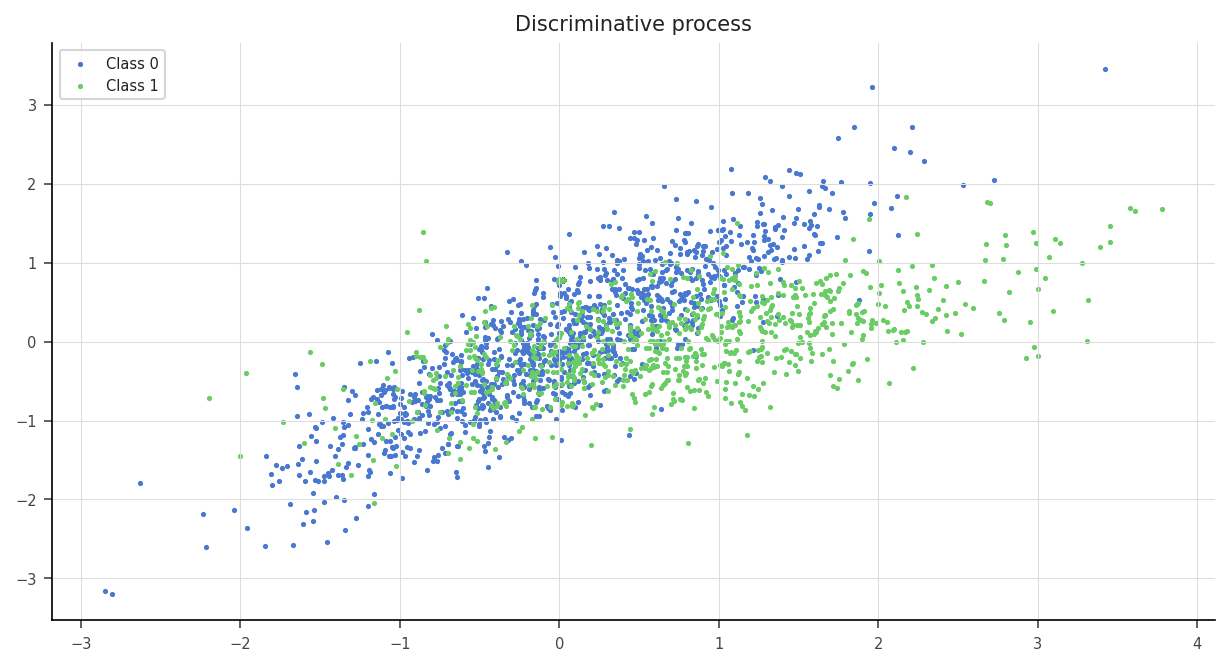

In [40]:
I0 = np.where(Y==0)
I1 = np.where(Y==1)

plt.figure(figsize=(10, 4))
plt.scatter(X[I0, 0], X[I0, 1], marker='.', label="Class 0")
plt.scatter(X[I1, 0], X[I1, 1],marker='.', label="Class 1")
plt.grid("on")
plt.legend()
plt.title("Discriminative process")
plt.show()

Of course, the computed datasets follow the same distribution, no matter the method used.

## Exercises
* For the lastly defined distributions, given three points $q=\{(0, 0), (3, 0), (0, 2)\}$, compute $P(\mathbf{y}| \mathbf{x}=q)$ for each class $y$. Compute $p(q|\mathbf{y}=y)$ for each class $y$ and $P(\mathbf{y}=y)$ for each class $y$.
* Can you adapt the two procedures to get higher-dimensional data (i.e. $x$ is not in $\mathbb{R}^2$ but in $\mathbb{R}^n$) ?
* Can you adapt the two procedures to get more-classes data (i.e. $y$ is not in $\{0, 1\}$ but in $\{1,...,c_{k}\}$) ?

### Question 1
Using Bayes' theorem:

$$P(\mathbf{y}= y | \mathbf{x} = q) = \frac{p(q | \mathbf{y} = y) P(\mathbf{y} = y)}{p(q)}$$

where the marginal likelihood $p(q)$ is given by:

$$p(q) = \sum_{y} p(q | \mathbf{y} = y) P(\mathbf{y} = y).$$

The likelihood $p(q | \mathbf{y} = y)$ follows the multivariate normal density function (available in `scipy`):

$$p(q | \mathbf{y} = y) = \frac{1}{(2\pi)^{d/2} |\Sigma_y|^{1/2}} \exp\left(-\frac{1}{2} (q - \mu_y)^T \Sigma_y^{-1} (q - \mu_y)\right),$$

where $d = 2$ is the dimensionality.

In [41]:
for q in [(0, 0), (3, 0), (0, 2)]:
    pq = multivariate_normal.pdf(q, mean=mu0, cov=cov0)*(1-p1) + multivariate_normal.pdf(q, mean=mu1, cov=cov1)*p1
    pprint(f"P(y=0|x={q}) = {multivariate_normal.pdf(q, mean=mu0, cov=cov0)*(1-p1)/pq:.4e}")

print()
for q in [(0, 0), (3, 0), (0, 2)]:
    pq = multivariate_normal.pdf(q, mean=mu0, cov=cov0)*(1-p1) + multivariate_normal.pdf(q, mean=mu1, cov=cov1)*p1
    pprint(f"P(y=1|x={q}) = {multivariate_normal.pdf(q, mean=mu1, cov=cov1)*p1/pq:.4e}")

print()
for q in [(0, 0), (3, 0), (0, 2)]:
    pprint(f"P(x={q}|y=0) = {multivariate_normal.pdf(q, mean=mu0, cov=cov0):.4e}")

print()
for q in [(0, 0), (3, 0), (0, 2)]:
    pprint(f"P(x={q}|y=1) = {multivariate_normal.pdf(q, mean=mu1, cov=cov1):.4e}")

print()
pprint(f"P(y=0) = {1-p1}")
pprint(f"P(y=1) = {p1}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Question 2

In [42]:
n = 5
Y = np.random.choice([0, 1], size=N, p=[1-p1, p1])

mu0 = np.zeros(n)
A0 = np.random.rand(n, n)
cov0 = A0.T @ A0

mu1 = np.array([0.75] + [0] * (n - 1))
A1 = np.random.rand(n, n)
cov1 = A1.T @ A1

X = np.zeros((N, n))
for i in range(N):
    if Y[i] == 1:
        X[i, :] = np.random.multivariate_normal(mu1, cov1, size=1)
    else:
        X[i, :] = np.random.multivariate_normal(mu0, cov0, size=1)

### Question 3

In [43]:
np.random.seed(1)
n = 2
c_k = 4

class_probs = [0.2, 0.3, 0.35, 0.15]
Y = np.random.choice(np.arange(c_k), size=N, p=class_probs)

mus = [np.random.uniform(-1, 1, size=n) for _ in range(c_k)]
covs = [np.random.rand(n, n) for _ in range(c_k)]
covs = [C.T @ C for C in covs]

X = np.zeros((N, n))
for i in range(N):
    cls = Y[i]
    X[i, :] = np.random.multivariate_normal(mus[cls], covs[cls], size=1)

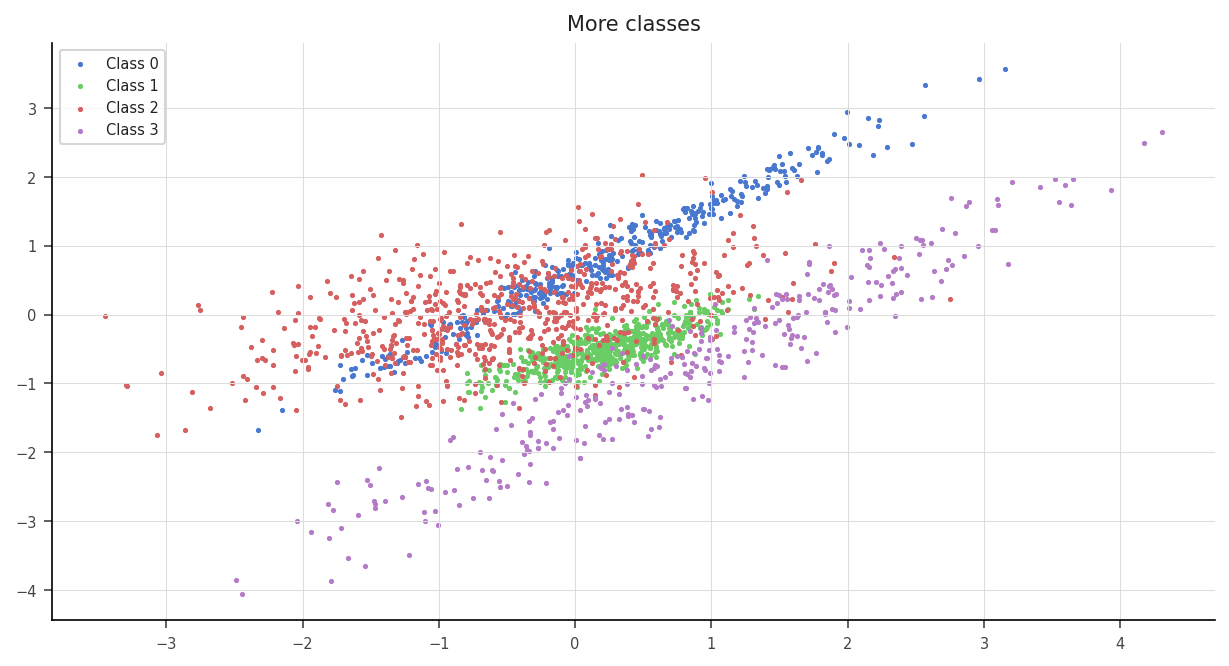

In [44]:
Is = [np.where(Y==i) for i in range(c_k)]

plt.figure(figsize=(10, 4))
for i in range(c_k):
    plt.scatter(X[Is[i], 0], X[Is[i], 1], marker='.', label=f"Class {i}")
plt.legend()
plt.grid("on")
plt.title("More classes")
plt.show()

Finally we regenerate binary data for the rest of the practical:

In [45]:
np.random.seed(1)
N = 4000
N_test = 1000
n = 2
p1 = 0.4

Y = np.random.choice([0, 1], size=N, p=[1-p1, p1])
A0 = np.array([[.45, .5], [.05, .35]])
cov0 = A0.T @ A0
mu0 = (0, 0)

A1 =  np.array([[.32, -.4], [-.4, .32]])
cov1 = A1.T @ A1
mu1 = (.5, 0)
X = np.zeros((N, n))
for i in np.arange(N):
    if Y[i] == 1:
        X[i, :] = np.random.multivariate_normal(mu1, cov1, size=1)
    else:
        X[i, :] = np.random.multivariate_normal(mu0, cov0, size=1)

Y_test = np.random.choice([0, 1], size=N_test, p=[1-p1, p1])
X_test = np.zeros((N_test, n))
for i in np.arange(N_test):
    if Y_test[i] == 1:
        X_test[i, :] = np.random.multivariate_normal(mu1, cov1, size=1)
    else:
        X_test[i, :] = np.random.multivariate_normal(mu0, cov0, size=1)

## Metrics and model evaluations methods
In the previous practicals, when we were dealing with regression tasks, we defined different metrics for evaluating the quality of some model's predictions. Remind: we defined the Mean Squared Error, then, we normalized it to define the Normalized Mean Squared Error. We spoke about other metrics, such as the MAE. All those quantities, while highly informative when applied to continuous quantities, are not as useful when dealing with classes.

Let us consider a practical example. You are assigned the task to determine if some rocket components are working (1) or not (0). In this task, it seems clear that the fact of assigning _working_ to a _non-working_ piece is worse than assigning _non-working_ to a _working_ piece (you could lose astronauts). However, this is not reflected by the MSE: in both cases, assigning the wrong label would lead to an error of $1$. 

In binary classification, however, we can determine entirely the cases possible after prediction:
* Expected: 0, Predicted: 0 -> True Negative (TN)
* Expected: 1, Predicted: 1 -> True Positive (TP)
* Expected: 0, Predicted: 1 -> False Positive (FP)
* Expected: 1, Predicted: 0 -> False Negative (FN)

In this terminology, it is clear that the previous example suffers more from the False Positives than the False Negatives.

We can present those quantities in a matrix, called the *confusion matrix*:

| |Real Class: Negative|Real Class: Positive|
|-|-|-|
|Classified as negative|TN|FN|
|Classified as positive|FP|TP|

In `sklearn`, the function `confusion_matrix` builds it from the set of expected and predicted labels. That is, if a model outputs a score (which is the case for most of them), for a given threshold on those scores the classes are determined, then the confusion matrix is built on top of those predictions. There exists a convenient `ConfusionMatrixDisplay` class, but take care, the cases are inverted when compared to the course notation. A confusion matrix, however, is not so-to-say a scoring method. There are different values, derived from the confusion matrix quantities, that allows to score a given prediction set:
* The **precision**: $\frac{\text{TP}}{\text{TP}+\text{FP}}$
* The **recall**: $\frac{\text{TP}}{\text{TP}+\text{FN}}$
* The **F1 score**: $\frac{2\text{TP}}{2\text{TP}+\text{FP}+\text{FN}}$ which is the harmonic mean between the precision and the recall scores
* More generally, the **F Beta score**:  $\frac{(1+\beta^2)\text{TP}}{(1+\beta^2)\text{TP}+\text{FP}+\beta^2\text{FN}}$
* The **accuracy**: $\frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}}$

However, those quantities often do not take into account the number of True Negatives. Note: most of those scoring methods are implemented in `sklearn`.

Let us define furthermore the _True Positive Rate_, i.e., the proportion of True Positive on all the indeed positive samples, and, conversely, the  _False Positive Rate_, the proportion of False Positive on all the in fact positive samples.

## Bayes classifier
Remind: for discrete inputs, the Bayes theorem states that:

$$P(y|x) = \frac{P(x|y)P(y)}{P(x)}$$

and this can be used as a classifier. More specifically, for continuous inputs, we have

$$P(\mathbf{y}=c_k|\mathbf{x}=x) = \frac{p_x(x|\mathbf{y}=c_k)P(\mathbf{y}=c_k)}{\sum_{k=1}^K p_x(x|\mathbf{y}=c_k)P(\mathbf{y}=c_k)}$$

Note, it requires to know what is the density function $p_x$. If we make the hypothesis that those follow a normal distribution (how could we test if this is valid ?). However, in practice, the $\mu$ and `cov` should be estimated from the data., we can use the `GaussianNB` class from `sklearn`.

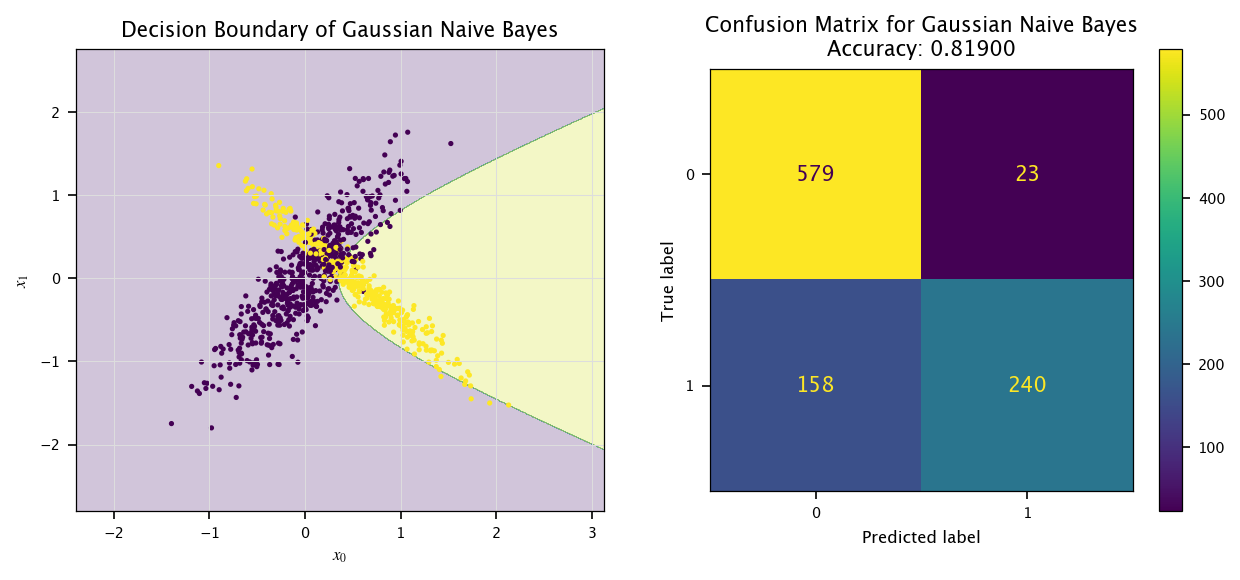

In [81]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def plot_field(X, Y, model, name=""):
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.linspace(x0_min, x0_max, 1000),
                           np.linspace(x1_min, x1_max, 1000))
    
    Z = model.predict(np.c_[xx0.ravel(), xx1.ravel()]).reshape(xx0.shape)
    Y_hat = model.predict(X) 
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].contourf(xx0, xx1, Z, alpha=0.25)
    ax[0].scatter(X[:, 0], X[:, 1], c=Y, marker='.')
    ax[0].grid("on")
    
    ax[0].set_xlabel("$x_0$")
    ax[0].set_ylabel("$x_1$")
    ax[0].set_title(f"Decision Boundary of {name}")
    ConfusionMatrixDisplay.from_predictions(Y, Y_hat, ax=ax[1])
    ax[1].set_title(f"Confusion Matrix for {name}\nAccuracy: {accuracy_score(Y, Y_hat):.5f}")
    plt.show()
    
model = GaussianNB().fit(X, Y.ravel())

plot_field(X_test, Y_test, model, "Gaussian Naive Bayes")

## Linear model for classification
As it has been done for the regression tasks, we can use a linear model for classifying the previously generated points. As an example, in `sklearn`, we can use the `LogisticRegression` class:

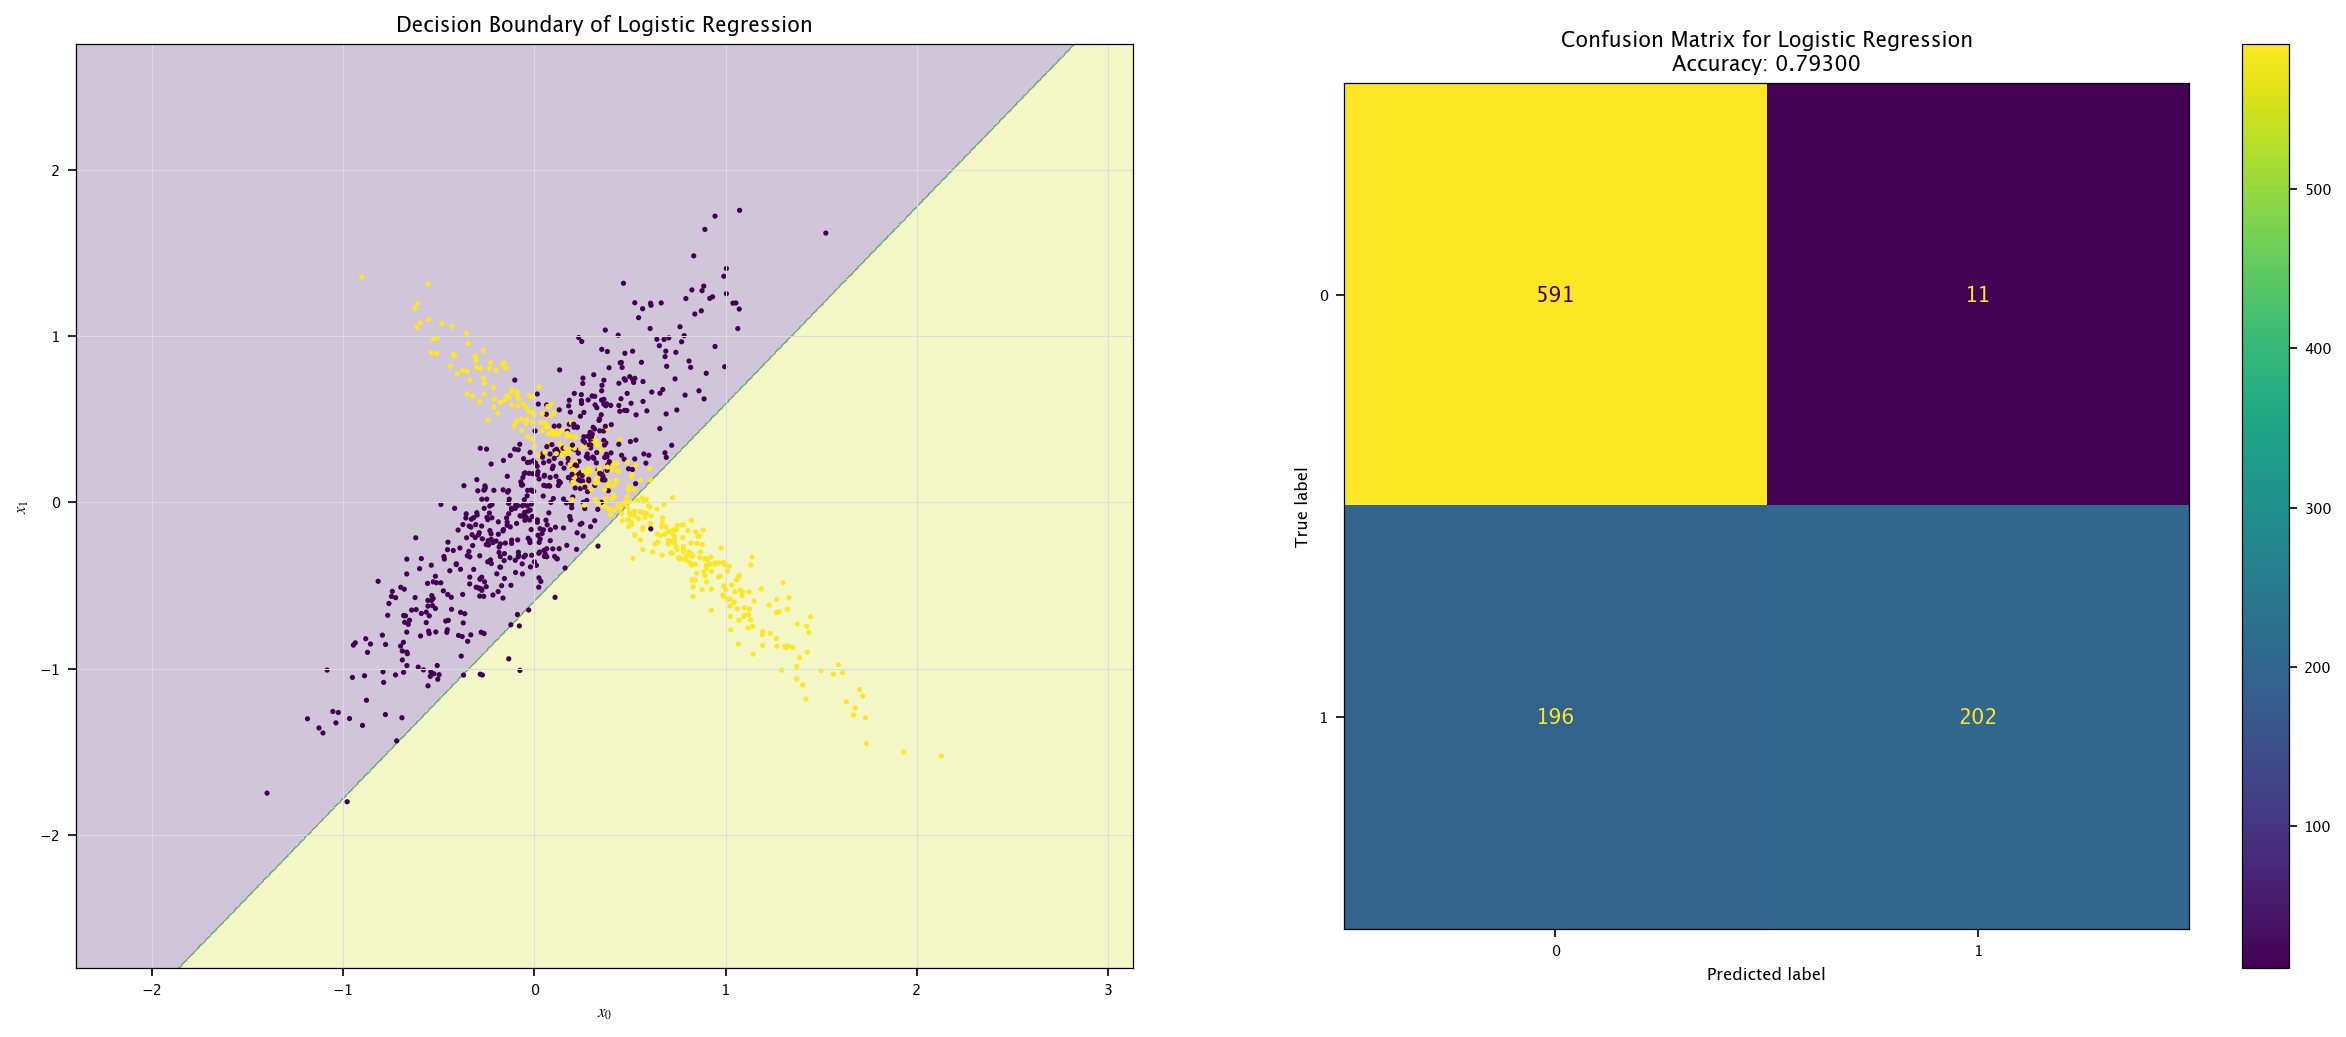

In [80]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X, Y.ravel())

plot_field(X_test, Y_test, model, "Logistic Regression")

### Multi-layers perceptron
Now, for fun, we can train another model to see how the space is then divided: 

In [29]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(max_iter=1000).fit(X, Y.ravel())

plot_field(X_test, Y_test, model, "MLP")

KeyboardInterrupt: 

## Exercises
### KNN
* Implement a KNN classifier (`sklearn.neighbors.KNeighborsClassifier`).
* Vary $k$ (e.g., 1, 5, 20) and visualize decision boundaries.
* Discuss underfitting/overfitting trade-offs.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

for k in (1, 5, 20):
    model = KNeighborsClassifier(k).fit(X, Y.ravel())
    plot_field(X_test, Y_test, model, f"{k}-NN")

### Bayes
* Compute the true Bayes decision boundary using the known densities $p(x|y)$.
* Compare it to the decision boundaries of logistic regression and KNN.
* Discuss the optimality of Bayes classification.

In [ ]:
p_x_given_y0 = multivariate_normal(mean=mu0, cov=cov0)
p_x_given_y1 = multivariate_normal(mean=mu1, cov=cov1)

x1, x2 = np.meshgrid(np.linspace(-2, 3, 1000), np.linspace(-2, 2, 1000))
grid = np.c_[x1.ravel(), x2.ravel()]

posterior_1 = p1 * p_x_given_y1.pdf(grid)
posterior_0 = (1 - p1) * p_x_given_y0.pdf(grid)

bayes_boundary = (posterior_1 > posterior_0).reshape(x1.shape)

plt.figure(figsize=(10, 10))
plt.contourf(x1, x2, bayes_boundary/2, alpha=0.25, cmap="turbo")
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, marker='.', cmap="turbo")
plt.title("Bayes Decision Boundary")
plt.show()

### Other models
* Use other models to classify tests' $X$ and $Y$ and show their decision boundaries.
* Compare their performances using the different metrics.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier().fit(X, Y.ravel())

plot_field(X_test, Y_test, model, "Random Forest")

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier().fit(X, Y.ravel())

plot_field(X_test, Y_test, model, "XGBoost")

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(8, 16, 8), max_iter=1000, random_state=1).fit(X, Y.ravel())

plot_field(X_test, Y_test, model, "MLP")

### More classes
* Generate a dataset with two features $x_1$, $x_2$, with classes in $\{0, 1, 2, 3\}$. The probability for each class is $[0.2, 0.3, 0.35, 0.15]$.
* Use a Logisitc Regression model to classify the points.
* Use a RandomForestClassifier and a MLPClassifier to classify the points.
* For the three models, show the confusion matrix.
* Using the same visualization function as before, show the decision boundaries of the three models: how are those boundaries related to the way those models work?

In [ ]:
np.random.seed(1)
n = 2
c_k = 4

class_probs = [0.2, 0.3, 0.35, 0.15]
Y4 = np.random.choice(np.arange(c_k), size=N, p=class_probs)

mus = [np.random.uniform(-1, 1, size=n) for _ in range(c_k)]
covs = [np.random.rand(n, n) for _ in range(c_k)]
covs = [C.T @ C for C in covs]

X4 = np.zeros((N, n))
for i in range(N):
    cls = Y4[i]
    X4[i, :] = np.random.multivariate_normal(mus[cls], covs[cls], size=1)

Y4_test = np.random.choice(np.arange(c_k), size=N_test, p=class_probs)
X4_test = np.zeros((N_test, n))
for i in range(N_test):
    cls = Y4_test[i]
    X4_test[i, :] = np.random.multivariate_normal(mus[cls], covs[cls], size=1)

In [ ]:
model = LogisticRegression().fit(X4, Y4.ravel())
plot_field(X4_test, Y4_test, model, "Logistic Regression")

In [82]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier().fit(X4, Y4.ravel())
plot_field(X4_test, Y4_test, model, "Random Forest")

model = MLPClassifier(max_iter=1000).fit(X4, Y4.ravel())
plot_field(X4_test, Y4_test, model, "MLP")

NameError: name 'X4' is not defined

## ROC curve
Let us define two important notions:
* The **sensibility**: $\frac{\text{TP}}{\text{TP}+\text{FN}}$. On all the indeed positive cases, what is the portion of correctly assigned positive?
* The **specificity**: $\frac{\text{TN}}{\text{TN}+\text{FP}}$. On all the indeed negative cases, what is the portion of correctly assigned negative?

Now, let us use a threshold model. That is, for a given threshold, if the sample is below, classify it as 0, otherwise classify it as 1. For multiple values of this threshold, the **ROC** curve (for _receiver operating characteristic_) is a plot in which the False Positive Rate is put in abscissa, and the sensibility in ordinate. The **precision/recall** plot displays the precision vs. the recall. Finally, the **lift** curve shows the proportion of _assigned positives_ among all the points (the _alert_ level).

We can define the notion of _area under the ROC curve_ (AUROC, often called AUC). In the best case, the area under the ROC curve is $1$.

### Exercise
* For the previous dataset, implement (by hand):
    * A KNN Classifier
    * A Naïve Bayes Classifier
* where both outputs a score
* Then, for multiple threshold value, compute the True Positive rate and the False Positive rate of both models
* Plot the ROC curve of both models.
* Compute the AUROC for both models. How can you use this as a modelquality assessment ?

In [ ]:
from scipy.stats import norm

def KNN(X, Y, q, k=15):
    N_local = X.shape[0]
    d = np.sqrt(np.sum((X - q) ** 2, axis=1))
    index = np.argsort(d)[:k]
    return np.count_nonzero(Y[index] == 1) / k

def NB(X, Y, q):
    # Recall: we make the hypothesis that the the inputs are conditionnally independent
    N = len(Y)
    n = X.shape[1]
    Yhat = np.zeros(N)
    I1 = np.where(Y == 1)[0]
    I0 = np.where(Y == 0)[0]
    p1 = len(I1) / N
    p0 = 1 - p1
    p1x = 1
    p0x = 1
    for j in range(n):
        mean_I1 = np.mean(X[I1, j])
        sd_I1 = np.std(X[I1, j], ddof=1)
        mean_I0 = np.mean(X[I0, j])
        sd_I0 = np.std(X[I0, j], ddof=1)
        p1x = p1x * norm.pdf(q[j], loc=mean_I1, scale=sd_I1)
        p0x = p0x * norm.pdf(q[j], loc=mean_I0, scale=sd_I0)
    Yhat = p1x * p1 / (p1x * p1 + p0x * p0)
    return Yhat

In [ ]:
plt.figure(figsize=(10, 4))
for model in [KNN, NB]:
    Y_hats_prob = []
    # Leave-one-out procedure
    for i in range(X.shape[0]):
        X_train = np.delete(X, i, axis=0)
        Y_train = np.delete(Y, i, axis=0)
        Y_hats_prob.append(model(X_train, Y_train, X[i]))
    
    Y_hats_prob = np.array(Y_hats_prob)

    thresholds = np.linspace(0, 1, 100)
    TPR = []
    FPR = []
    for t in thresholds:
        Y_hats = np.ones_like(Y)
        Y_hats[Y_hats_prob < t] = 0
        
        TP = np.sum((Y_hats == 1) & (Y == 1))
        TN = np.sum((Y_hats == 0) & (Y == 0))    
        FP = np.sum((Y_hats == 1) & (Y == 0))    
        FN = np.sum((Y_hats == 0) & (Y == 1))
    
        TPR.append(TP / (TP + FN) if (TP + FN) > 0 else 0)
        FPR.append(FP / (FP + TN) if (FP + TN) > 0 else 0)
    AUROC = 0
    for i in range(len(TPR)-1):
       AUROC += TPR[i+1]*(-FPR[i+1]+FPR[i])
    print(AUROC)
    plt.scatter(FPR, TPR)
    
plt.plot([0, 1], [0, 1], linestyle="dashed", color="gray")
plt.legend(["KNN", "NB"])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for KNN and NB")
plt.grid("on")
plt.show()

For recall, those are a few models for classification that output a score. Try to display their ROC curve as well. See slides 28-33 from the theoretical course for more information.

### More models
First, this model compute the mean of the two classes clusters, and then computes the score as a function of the distance between the query point and those two means.

In [ ]:
def MD(X, Y, q):
    N_local = len(Y)
    n = X.shape[1]
    I1_local = np.where(Y == 1)[0]
    I0_local = np.where(Y == 0)[0]
    mu1 = np.mean(X[I1_local, :], axis=0)
    mu0 = np.mean(X[I0_local, :], axis=0)
    d1 = np.sum((q - mu1) ** 2)
    d0 = np.sum((q - mu0) ** 2)
    return np.exp(-d1) / (np.exp(-d1) + np.exp(-d0))

In [ ]:
def QDA(Xtr, Ytr, q):
    n = Xtr.shape[1]
    Ntr = Xtr.shape[0]
    I0_local = np.where(Ytr == 0)[0]
    I1_local = np.where(Ytr == 1)[0]
    P0 = len(I0_local) / Ntr
    P1 = 1 - P0
    mu0 = np.mean(Xtr[I0_local, :], axis=0)
    Sigma0 = np.cov(Xtr[I0_local, :], rowvar=False)
    mu1 = np.mean(Xtr[I1_local, :], axis=0)
    Sigma1 = np.cov(Xtr[I1_local, :], rowvar=False)
    xts = np.array([q])
    diff0 = xts - mu0
    inv_Sigma0 = np.linalg.inv(Sigma0)
    quad0 = diff0.dot(inv_Sigma0).dot(diff0.T)[0, 0]
    g0 = -0.5 * quad0 - n/2 * np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(Sigma0)) + np.log(P0)
    diff1 = xts - mu1
    inv_Sigma1 = np.linalg.inv(Sigma1)
    quad1 = diff1.dot(inv_Sigma1).dot(diff1.T)[0, 0]
    g1 = -0.5 * quad1 - n/2 * np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(Sigma1)) + np.log(P1)
    return np.exp(g1) / (np.exp(g0) + np.exp(g1))

In [ ]:
def LDA(Xtr, Ytr, q):
    n = Xtr.shape[1]
    Ntr = Xtr.shape[0]
    I0_local = np.where(Ytr == 0)[0]
    I1_local = np.where(Ytr == 1)[0]
    P0 = len(I0_local) / Ntr
    P1 = 1 - P0
    sigma2 = np.mean(np.var(Xtr, axis=0, ddof=1))
    mu0 = np.mean(Xtr[I0_local, :], axis=0)
    mu1 = np.mean(Xtr[I1_local, :], axis=0)
    g0 = -1/(2*sigma2) * np.linalg.norm(q-mu0) + np.log(P0)
    g1 = -1/(2*sigma2) * np.linalg.norm(q-mu1) + np.log(P1)
    return np.exp(g1) / (np.exp(g0) + np.exp(g1))

## Unequal costs
When the cost associated with False Negatives and False Positive are not equal, the computation cannot be used as is. Let us define two costs: $L_{FP}$ and $L_{FN}$. Keep in mind, here, that we consider the two other costs $L_{TP}, L_{TN} = 0$. The expected cost for each possible decision is $L(1|x) = P(\mathbf{y}=0|x)L_{FP}$ and $L(0|x) = P(\mathbf{y}=1|x)L_{FN}$. The two _a posteriori_ probabilities $P(y|x)$ can be estimated from the data. If we have $P(\mathbf{y}=1|x)$, for a sample $x$, we want to assign the class that minimizes the expected cost.

We predict

$$
\hat{y} =
\begin{cases} 
1, & \text{if } L(1|x) < L(0|x) \Leftrightarrow (1 - P(y=1|x)) L_{FP} < P(y=1|x) L_{FN}, \\
0, & \text{otherwise}.
\end{cases}
$$

We can rewrite this as

$$P(\mathbf{y}=1|x) > \frac{L_{FN}}{L_{FP}+L_{FN}}$$

* If $L_{FP} = L_{FN}$, then $\frac{L_{FN}}{L_{FP}+L_{FN}} = \frac12$. This is the classic case, where we output the maximum a posteriori class.
* If $L_{FP} > L_{FN}$, then it is better to output $y=1$, this reduces the number of FP.
* Otherwise, it is better to output $y=0$.

### Exercise
* In the generated data, suppose that having a FN has a cost of $1$ while having a FP has a costof $0.2$. What is the threshold and the optimal class ?

The threshold is $\frac{1}{1.2} = 0.833$. The optimal class is therefore the class $0$.